In [ ]:
import json
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
label_data_list = glob.glob('/content/drive/MyDrive/Kiosk/Dataset/Data/label/train/*.json')

NameError: name 'glob' is not defined

In [ ]:
anotaiton

{'maxX': 2073.2546049999996,
 'maxY': 1486.204442,
 'minX': 1338.2201049999999,
 'minY': 539.5066419999999}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
except_list = []

for label_data_path in label_data_list:
    label_data = json.load(open(label_data_path,encoding='cp949'))
    emotion_path = label_data_path.split('_')[-1].split('.')[0] # 감정 디렉토리 추출

    for i in tqdm(range(len(label_data))):
        image_file_name = label_data[i]['filename'] # 이미지 파일 이름
        age =  label_data[i]['age'] # 나이
        gender = label_data[i]['gender'] # 성별
        anotaiton = label_data[i]['annot_B']['boxes'] # 박스
        area = (anotaiton['minX'], anotaiton['minY'], anotaiton['maxX'], anotaiton['maxY'])
        test_image_path = "/content/drive/MyDrive/Kiosk/Dataset/Data/img/train/" + emotion_path + "/" + image_file_name # 이미지 불러오기

        try :

            temp_image = Image.open(test_image_path)
            img_cropped = temp_image.crop(area)
            img_cropped = img_cropped.resize((255, 255))
            save_file_path = "/content/drive/MyDrive/Kiosk/Dataset/Crop/train/" + emotion_path + "/" + image_file_name
            # print(save_file_path)
            img_cropped.save(save_file_path)

            # display(img_cropped)
        except :
            except_list.append(image_file_name)
            continue
print(len(except_list))

NameError: name 'label_data_list' is not defined

# 성별 모델링

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
import time
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import torch.nn.functional as F
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None, target_transform=None):
        self.files = files
        self.transform=transform
        self.target_transform = target_transform
        self.path = root


    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image_file_name = self.files[index]['image'].split('/')[-1]
        image_path = self.path + image_file_name
        image = Image.open(image_path)

        if 'F' == self.files[index]['gender']:
            label = 0
        else:
            label = 1

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            image = self.target_transform(image)

        return image, torch.tensor([label]).float()

In [ ]:
train_label_json = json.load(open('/content/drive/MyDrive/제목없는 폴더/face_crop/label/labels_v1.json',encoding='cp949'))
test_label_json = json.load(open('/content/drive/MyDrive/제목없는 폴더/face_crop/test_label/test_labels_v1.json',encoding='cp949'))


train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
])

train_datset_path = '/content/drive/MyDrive/제목없는 폴더/face_crop/img/'
test_datset_path = '/content/drive/MyDrive/제목없는 폴더/face_crop/test_img/'

train_datset = CustomDataset(train_label_json, train_datset_path, transform=train_transform)
test_datset = CustomDataset(test_label_json, test_datset_path, target_transform=test_transform)

In [ ]:
train_dataloader = DataLoader(train_datset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_datset, batch_size=256, shuffle=True)

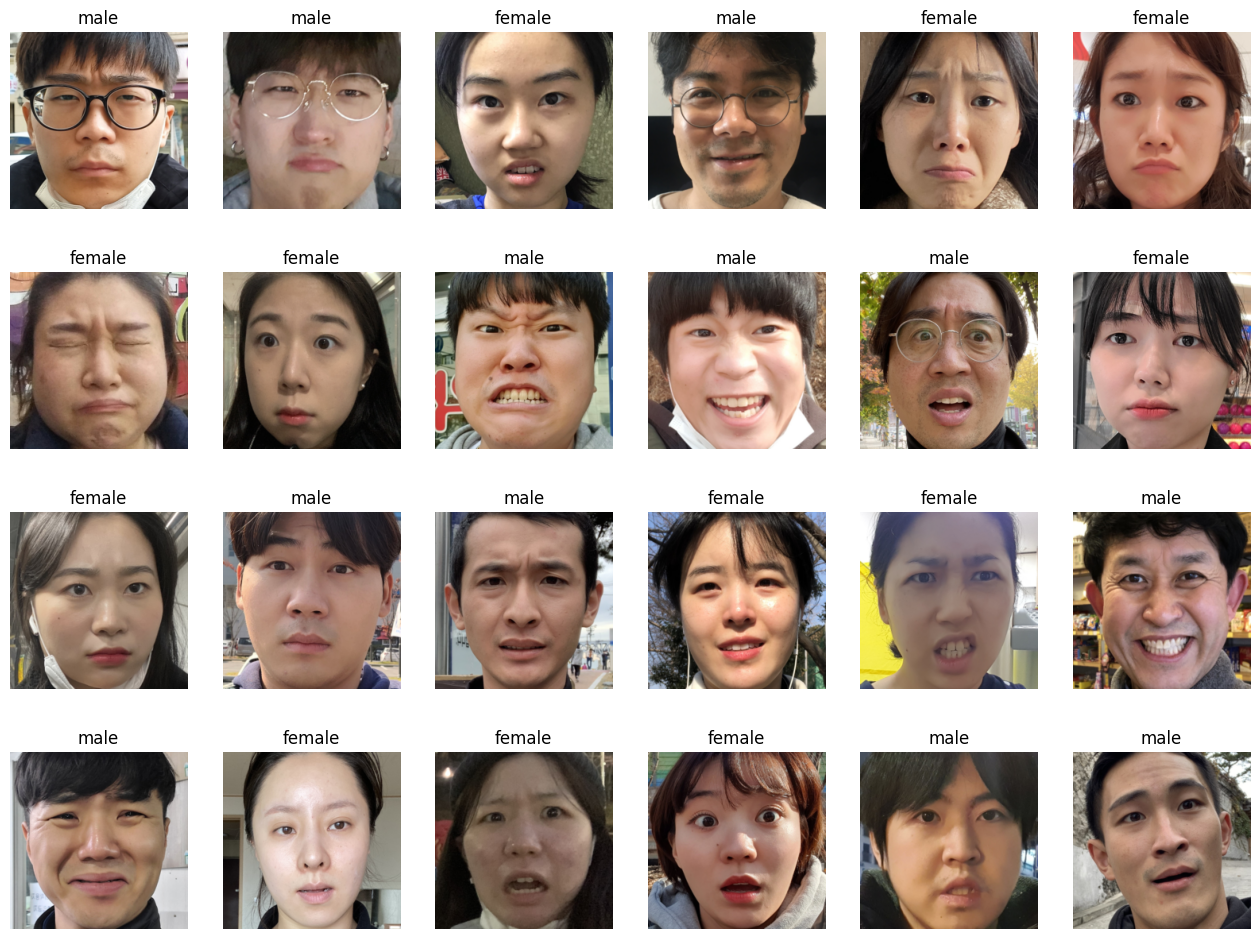

In [ ]:
samples, labels = next(iter(train_dataloader))
classes = {0:'female', 1:'male'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
model = torchvision.models.resnet18(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader=None):

    if valid_loader is None:
        valid_loader = train_loader

    model.to(device)
    criterion.to(device)

    model.train()

    train_loss = 0
    train_acc = 0
    train_correct = 0

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in tqdm(range(epochs)):
        start = time.time()
        for train_x, train_y in tqdm(train_loader):
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()

        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in tqdm(valid_loader):
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()

            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()

        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)

        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')

        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)

        train_loss = 0
        train_acc = 0
        train_correct = 0

    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()

    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

141.083sec : [Epoch 1/10] -> train loss: 0.5979, train acc: 71.221% / valid loss: 0.4824, valid acc: 88.833%


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

140.831sec : [Epoch 2/10] -> train loss: 0.3777, train acc: 89.723% / valid loss: 0.2616, valid acc: 93.250%


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

140.913sec : [Epoch 3/10] -> train loss: 0.2178, train acc: 94.027% / valid loss: 0.1747, valid acc: 94.333%


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

141.012sec : [Epoch 4/10] -> train loss: 0.1445, train acc: 95.746% / valid loss: 0.1307, valid acc: 95.917%


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

141.098sec : [Epoch 5/10] -> train loss: 0.1044, train acc: 96.697% / valid loss: 0.1026, valid acc: 96.250%


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

140.900sec : [Epoch 6/10] -> train loss: 0.0813, train acc: 97.364% / valid loss: 0.0859, valid acc: 96.750%


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

140.823sec : [Epoch 7/10] -> train loss: 0.0611, train acc: 98.265% / valid loss: 0.0765, valid acc: 97.083%


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

140.799sec : [Epoch 8/10] -> train loss: 0.0462, train acc: 98.749% / valid loss: 0.0669, valid acc: 97.417%


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

140.425sec : [Epoch 9/10] -> train loss: 0.0364, train acc: 98.966% / valid loss: 0.0600, valid acc: 97.583%


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

140.786sec : [Epoch 10/10] -> train loss: 0.0280, train acc: 99.399% / valid loss: 0.0565, valid acc: 98.000%


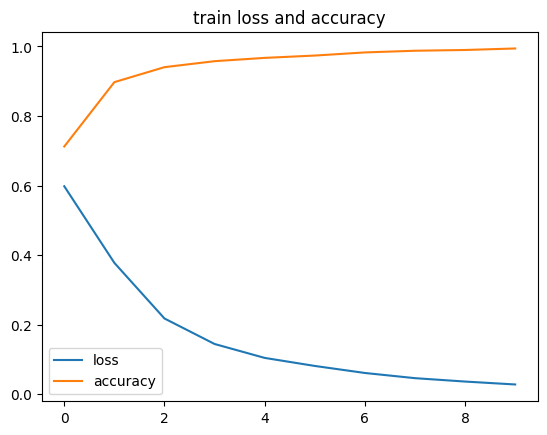

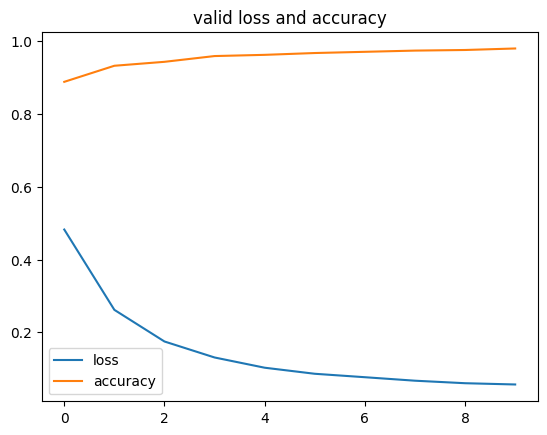

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

fit(model, criterion, optimizer, 10, train_dataloader, test_dataloader)

# 검증

In [ ]:
def model_val(model):
  model = model.to(device)
  val_datset_path = '/content/drive/MyDrive/제목없는 폴더/face_crop/val_img/'

  val_label_json = json.load(open('/content/drive/MyDrive/제목없는 폴더/face_crop/val_label/val_labels_v1.json',encoding='cp949'))
  val_datset = CustomDataset(val_label_json, val_datset_path, target_transform=test_transform)
  val_dataloader = DataLoader(test_datset, batch_size=256, shuffle=True)

  valid_loss = 0
  valid_acc = 0
  valid_correct = 0
  for valid_x, valid_y in tqdm(val_dataloader):
      with torch.no_grad():
          model.eval()
          valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
          pred = model(valid_x)
          loss = criterion(pred, valid_y)

      valid_loss += loss.item()

      y_pred = pred.cpu()
      y_pred[y_pred >= 0.5] = 1
      y_pred[y_pred < 0.5] = 0
      valid_correct += y_pred.eq(valid_y.cpu()).int().sum()

  valid_acc = valid_correct/len(val_dataloader.dataset)
  print(valid_acc)

# 임의 사진 확인

In [ ]:
image = Image.open('/content/drive/MyDrive/제목없는 폴더/스크린샷 2024-08-28 145700.jpg')
image = test_transform(image)

image = image.unsqueeze(0)
image = image.to(device)

model(image)

tensor([[0.9913]], device='cuda:0', grad_fn=<SigmoidBackward0>)

# 모델 저장

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model/genger_model_estOnly_v1.pth')

# 모델 불러오기

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

model.load_state_dict(torch.load('/content/drive/MyDrive/model/genger_model_estOnly_v1.pth'))
model_val(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-112-6c8df895600e>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more deta

  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.9792)
